# SEPSIS PREDICTION MODEL 

Import the necessary libraries and packages used.

In [29]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

Here the platform i used was Kaggle as it provides free GPU along with 16 GB RAM.

In [30]:
trainA = '/kaggle/input/physionet-challenge-2019early-detection-of-sepsis/training_setA/training'
print('training setA have {} files'.format(len(os.listdir(trainA))))
trainB = '/kaggle/input/physionet-challenge-2019early-detection-of-sepsis/training_setB/training_setB'
print('training setA have {} files'.format(len(os.listdir(trainB))))

training setA have 20336 files
training setA have 20000 files


In [31]:
os.chdir('/kaggle/input/physionet-challenge-2019early-detection-of-sepsis/training_setA/training')
extension ='psv'
filenames = [i for i in glob.glob('*{}'.format(extension))]

Extract data from each files in the Training A folder of our dataset. Patience is important parameter here(lol !), as we are extracting and concatinating data from 20,000 files on the go.

In [32]:
trainn = pd.concat([pd.read_csv(f , sep='|') for f in filenames])
trainn.to_csv('trainn.csv', index=False)

OSError: [Errno 30] Read-only file system: 'trainn.csv'

Save the data extracted in to a new file called 'trainn' and check whether you are doing right! Also, check for missing values!

In [33]:
trainn.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,1,0
1,83.0,94.0,NaN,111.0,73.0,NaN,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,2,0
2,66.0,95.0,NaN,95.0,64.0,NaN,17.0,NaN,NaN,NaN,...,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,3,0
3,75.5,90.5,37.0,131.5,74.0,NaN,27.0,NaN,NaN,NaN,...,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,4,0
4,70.5,98.0,NaN,144.0,81.0,NaN,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,5,0


In [34]:
trainn.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [35]:
a,b = trainn.shape
x   = trainn.size
if ( a*b!= x):
    print('There is missing values! Clean it!')
else:
    print('There is no missing values! Yet there may be NAN values.')       

There is no missing values! Yet there may be NAN values.


In [36]:
print('The dimensions of the given Training A dataset is:',trainn.shape)
print('The total number of data in given Training A dataset is',trainn.size)

The dimensions of the given Training A dataset is: (790215, 41)
The total number of data in given Training A dataset is 32398815


Wow! Awesome...You are dealing with 790215 patients 

Let check how many pateints are affected by Sepsis in this 790215 population.

'0' -> Patients without Sepsis     | '1'-> Pateints affected by Sepsis

0    773079
1     17136
Name: SepsisLabel, dtype: int64

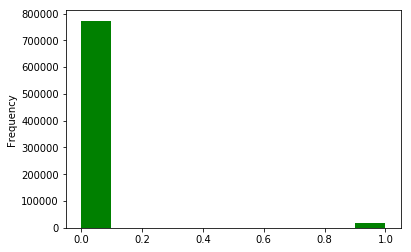

In [37]:
trainn.SepsisLabel.plot.hist( color = "g")
trainn['SepsisLabel'].value_counts()

Look out for the features that give us best Correlation with Target variable(SepsisLabel)
Hence, let us use seaborn to check out our best correlation b\w features with target feature.

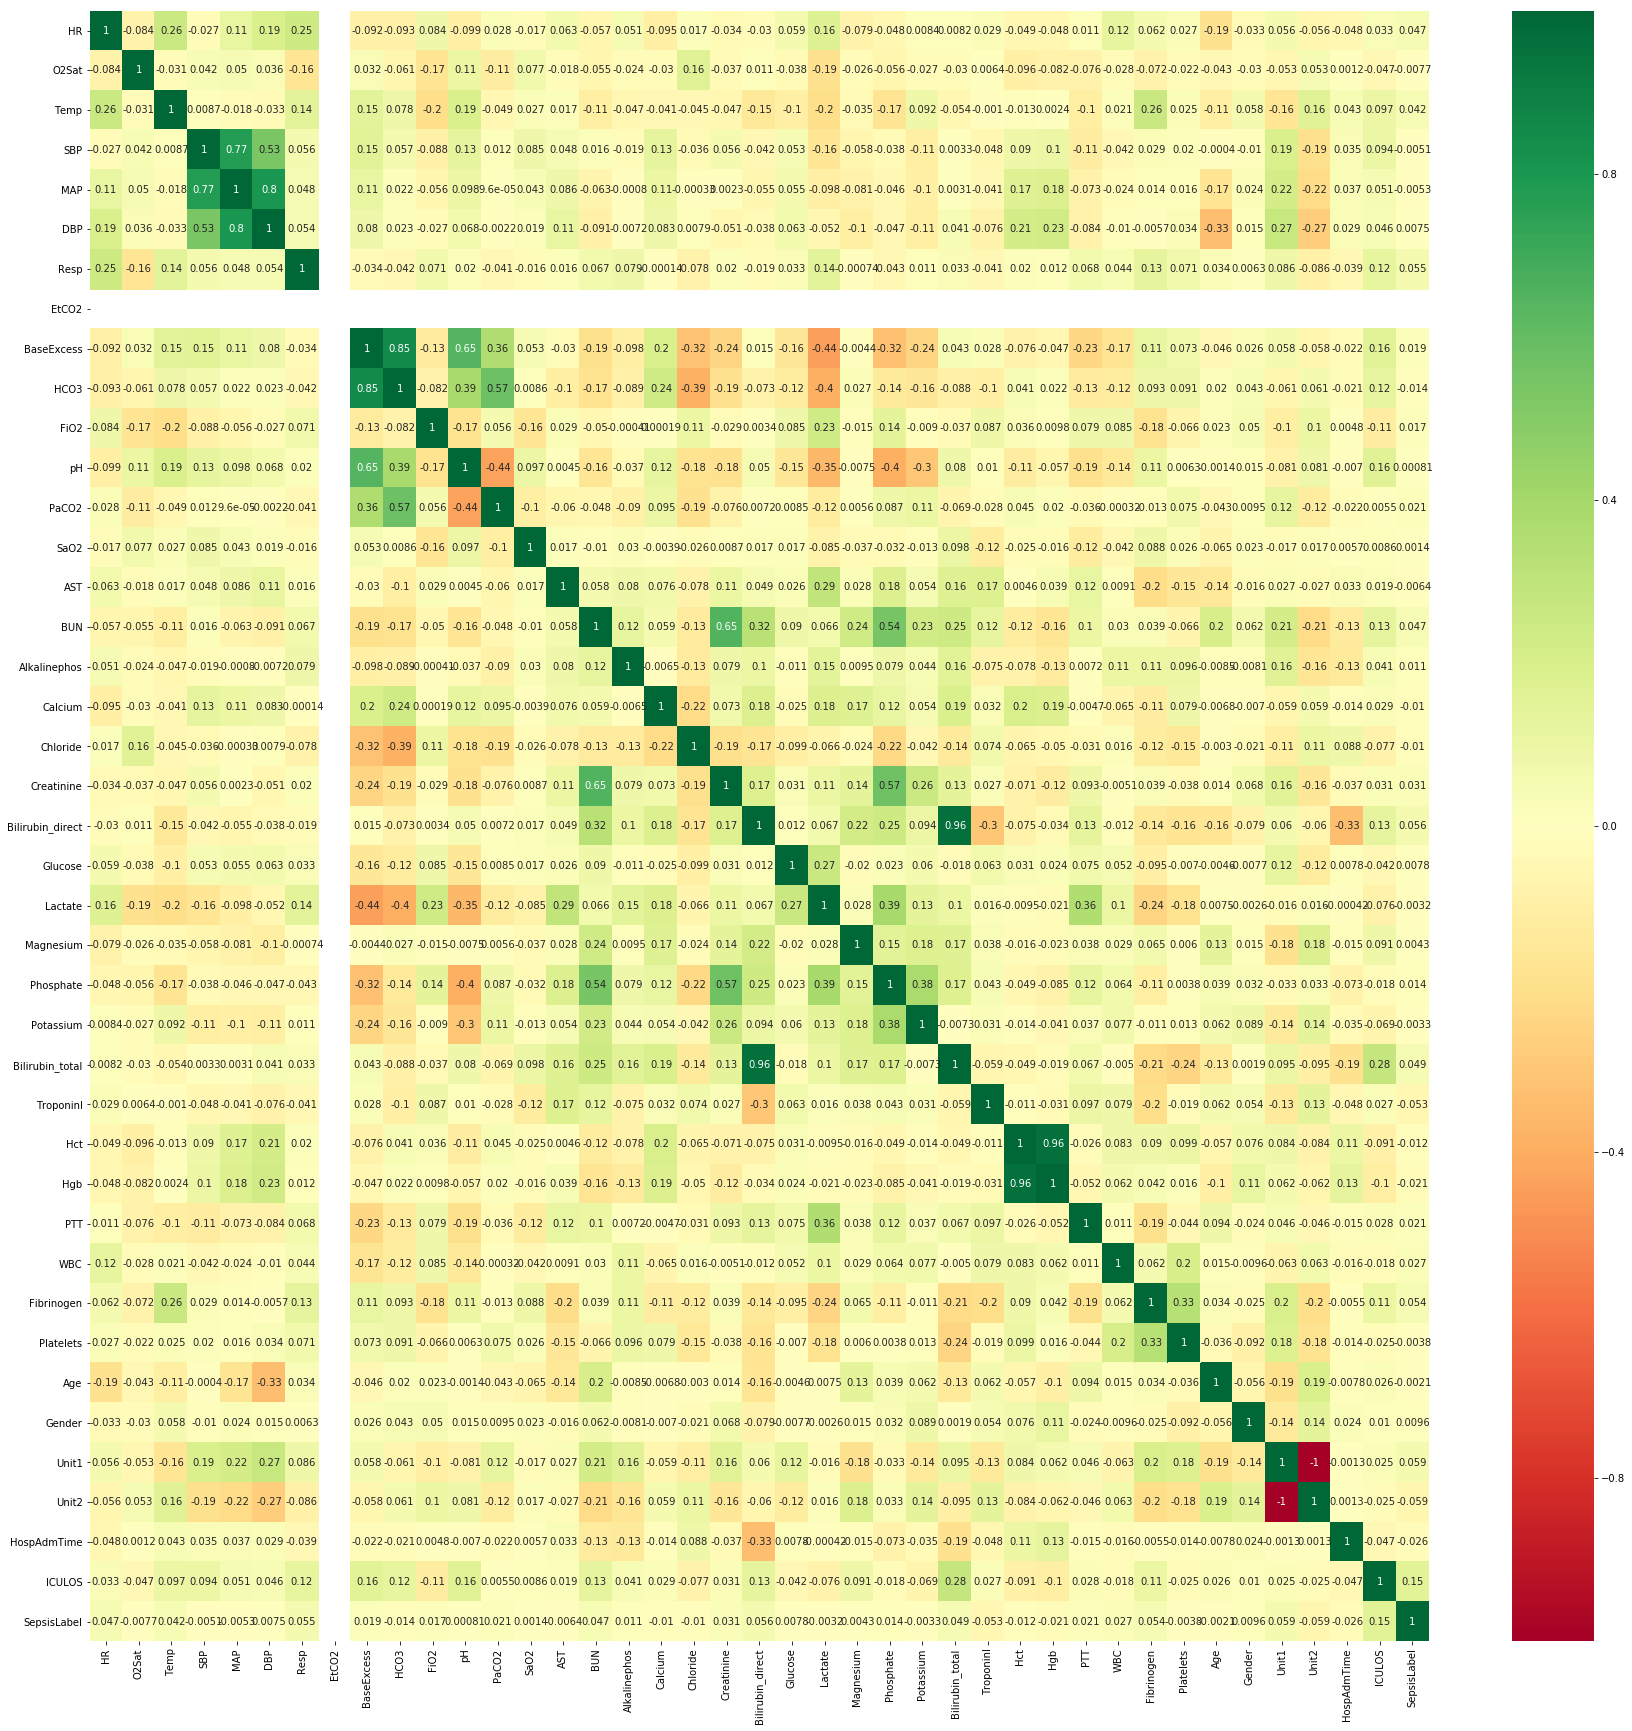

In [38]:
corrmat = trainn.corr()
top = corrmat.index
plt.figure(figsize=(30,30))
g = sns.heatmap(trainn[top].corr(), annot= True, cmap ="RdYlGn")

Chose your Independent features and Target variable and eliminate unwanted features.

In [39]:
features = trainn.drop(columns =['SepsisLabel','EtCO2','SBP','MAP','DBP','SaO2','Potassium','Lactate','Glucose','AST','Hct', 'Hgb'])
features.head()

,HR,O2Sat,Temp,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,BUN,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,1
1,83.0,94.0,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,2
2,66.0,95.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,3
3,75.5,90.5,37.0,27.0,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,4
4,70.5,98.0,NaN,24.0,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.36,0,NaN,NaN,-50.91,5


In [40]:
print(features.shape)
print(features.size)

(790215, 29)
22916235


In [ ]:
training_features, testing_features, training_target, testing_target = train_test_split(features, trainn['SepsisLabel'],train_size=0.80, test_size=0.20)
training_features.shape, testing_features.shape, training_target.shape, testing_target.shape

This dataset has many NAN values, so let's impute the missing values

In [41]:
imputer = SimpleImputer(strategy="median")
imputer.fit(training_features)
training_features = imputer.transform(training_features)
testing_features = imputer.transform(testing_features)

It is unbelievably a large dataset to be handled by this platform. 

In [42]:
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    ExtraTreesClassifier( n_estimators=100, criterion="entropy", max_features="auto", min_samples_leaf=1, min_samples_split=5)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

Stricitly make use of GPU's to train your model. I used Kaggle Kernels to train my models.

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_target,results)
cm

array([[154604,     55],
       [  2726,    658]])

In [46]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(testing_target,results)
accuracy

0.9824035230918168